In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path 

# Load the filtered dataset
data = pd.read_csv(Path(r'../SECOND BLOCK/filtered_flights_data.csv'))

data.head(5)

,status,type,dep_iata,dep_icao,dep_terminal,dep_gate,dep_delay,dep_scheduled_time,dep_actual_time,dep_estimated_time,...,prev_arr_delay,prev_origin,gate_turnaround_min,is_delayed_25,cond_grouped,route_volume_weight,route_risk_score,hourly_dep_count,hourly_arr_count,total_airport_load
0,active,departure,mad,lemd,NaN,NaN,34.0,2024-12-01 03:25:00,2024-12-01 03:59:00,2024-12-01t04:00:00.000,...,NaN,NaN,NaN,True,Partially cloudy,0.471304,30.096907,1,3.0,4.0
1,active,departure,mad,lemd,4,h3,21.0,2024-12-01 05:00:00,2024-12-01 05:20:00,2024-12-01t05:00:00.000,...,NaN,NaN,NaN,False,Partially cloudy,0.660019,26.748159,3,12.0,15.0
2,active,departure,mad,lemd,1,b29,18.0,2024-12-01 05:45:00,2024-12-01 06:02:00,2024-12-01t06:03:00.000,...,NaN,NaN,NaN,False,Partially cloudy,0.170233,38.324786,3,12.0,15.0
3,active,departure,mad,lemd,2,d,11.0,2024-12-01 05:50:00,2024-12-01 06:00:00,2024-12-01t06:01:00.000,...,NaN,NaN,NaN,False,Partially cloudy,0.804961,27.995773,3,12.0,15.0
4,active,departure,mad,lemd,2,e69,16.0,2024-12-01 06:00:00,2024-12-01 06:16:00,2024-12-01t06:15:00.000,...,NaN,NaN,NaN,False,Partially cloudy,0.535992,30.937443,21,2.0,23.0


In [2]:
# Print columns and number of missing values
print(data.isnull().sum())

status                      0
type                        0
dep_iata                    0
dep_icao                    0
dep_terminal             2986
dep_gate                16216
dep_delay                   0
dep_scheduled_time          0
dep_actual_time          8861
dep_estimated_time        255
dep_actual_runway        8861
dep_estimated_runway     8861
arr_iata                    0
arr_icao                    0
arr_terminal            25283
arr_gate                49092
arr_baggage_claim       31881
arr_delay               45636
arr_scheduled_time          0
arr_actual_time         58658
arr_estimated_time       9578
airline_name                0
airline_iata              682
airline_icao               14
flight_number               0
flight_iata             59376
flight_icao                14
aircraft_reg            59376
aircraft_model          59376
dep_hour                    0
dep_day_of_week             0
dep_month                   0
date                        0
temp      

In [3]:
# Columns to drop
cols_to_drop = [
    'arr_actual_time',      # 58658 missing
    'flight_iata',          # 59376 missing
    'aircraft_reg',         # 59376 missing
    'aircraft_model',       # 59376 missing
    'prev_arr_actual_time', # 58982 missing
    'prev_arr_delay',       # 59291 missing
    'prev_origin',          # 58982 missing
    'gate_turnaround_min',  # 58982 missing
]

data = data.drop(columns=cols_to_drop)

In [4]:
# Remove features that cause data leakage

leakage_cols = [
    # Actual departure data
    'dep_actual_time',
    'dep_actual_runway',
    'dep_estimated_runway',
    
    # Arrival data
    'arr_delay',
    'arr_estimated_time',
    'arr_gate',           # Assigned close to arrival
    'arr_baggage_claim',  # Assigned after landing
    
    # Target variable (we'll use dep_delay to create our own target)
    'is_delayed_15',
    
    # Status
    'status',
]

# Drop leakage columns
cols_to_remove = [c for c in leakage_cols if c in data.columns]
data = data.drop(columns=cols_to_remove)

# Fill arr_terminal with Unknown, keep for testing
data['arr_terminal'] = data['arr_terminal'].fillna('Unknown')

print("Columns removed due to data leakage:")
for col in cols_to_remove:
    print(f"  - {col}")

print(f"\nRemaining columns: {len(data.columns)}")
print(f"arr_terminal kept and filled with 'Unknown' for missing values")

Columns removed due to data leakage:
  - dep_actual_time
  - dep_actual_runway
  - dep_estimated_runway
  - arr_delay
  - arr_estimated_time
  - arr_gate
  - arr_baggage_claim
  - status

Remaining columns: 36
arr_terminal kept and filled with 'Unknown' for missing values


In [5]:
# Print remaining columns and number of missing values
print("\nRemaining columns and missing values:")
print(data.isnull().sum())


Remaining columns and missing values:
type                       0
dep_iata                   0
dep_icao                   0
dep_terminal            2986
dep_gate               16216
dep_delay                  0
dep_scheduled_time         0
dep_estimated_time       255
arr_iata                   0
arr_icao                   0
arr_terminal               0
arr_scheduled_time         0
airline_name               0
airline_iata             682
airline_icao              14
flight_number              0
flight_icao               14
dep_hour                   0
dep_day_of_week            0
dep_month                  0
date                       0
temp                       0
precip                     0
windspeed                  0
winddir                    0
visibility               131
cloudcover                 0
conditions                 0
gate_id                16216
is_delayed_25              0
cond_grouped               0
route_volume_weight        0
route_risk_score           0
hour

In [6]:
# Compare class distributions for different thresholds
print("Class Distribution Comparison:")
print("="*50)

for threshold in [15, 20, 25, 30, 45, 60]:
    delayed = (data['dep_delay'] >= threshold).mean() * 100
    print(f"{threshold} min: Delayed {delayed:.1f}% | On-time {100-delayed:.1f}%")

Class Distribution Comparison:
15 min: Delayed 84.2% | On-time 15.8%
20 min: Delayed 65.1% | On-time 34.9%
25 min: Delayed 47.8% | On-time 52.2%
30 min: Delayed 34.6% | On-time 65.4%
45 min: Delayed 12.6% | On-time 87.4%
60 min: Delayed 5.3% | On-time 94.7%


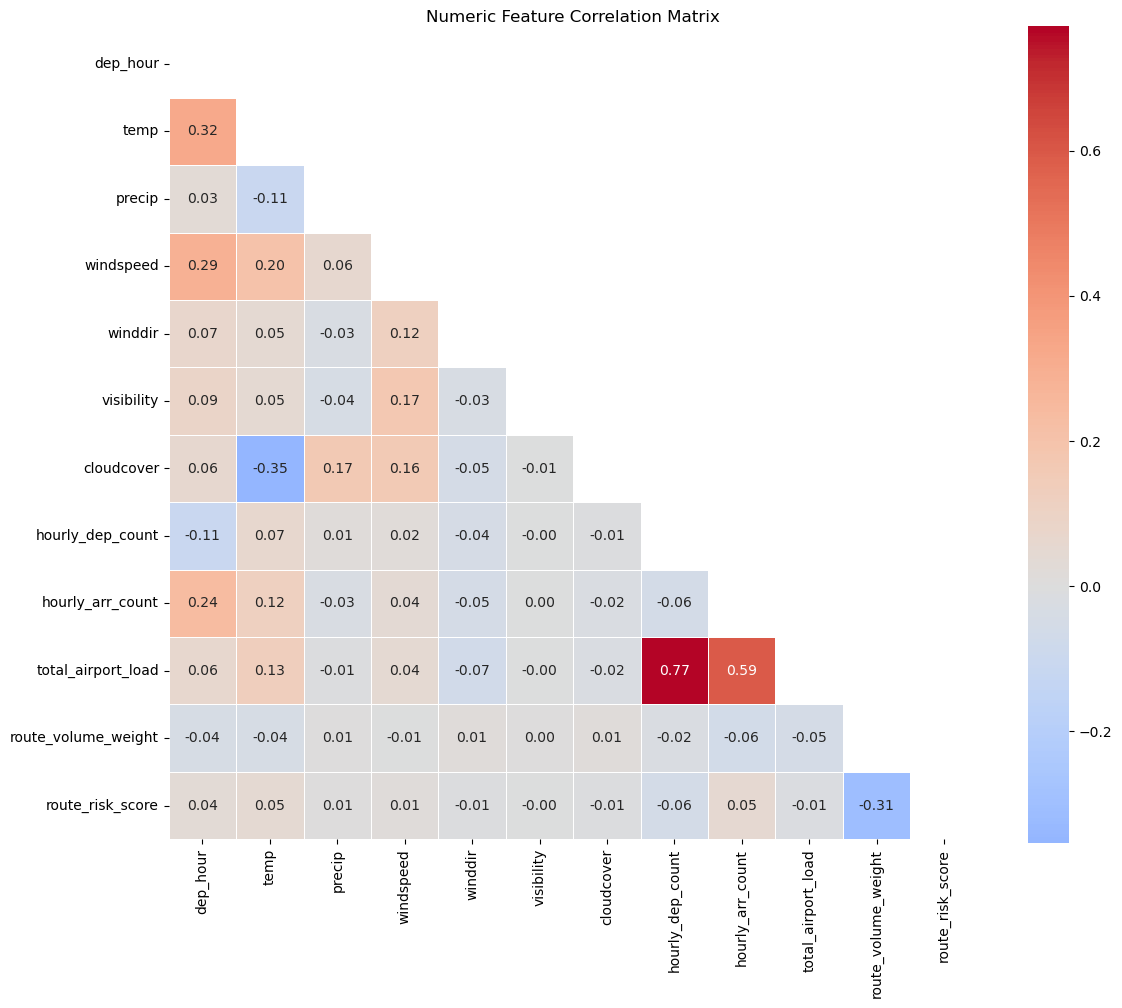


Highly Correlated Pairs (|r| > 0.7):
--------------------------------------------------
hourly_dep_count <-> total_airport_load: 0.771

Average unique values per group (1.0 = perfect redundancy):
  arr_iata vs arr_icao: 1.00 REDUNDANT
  airline_iata vs airline_icao: 1.01 OK
  airline_name vs airline_iata: 0.72 OK


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# CORRELATION ANALYSIS (Numeric Features Only)
numeric_features = [
    'dep_hour', 'temp', 'precip', 'windspeed', 'winddir', 'visibility', 'cloudcover',
    'hourly_dep_count', 'hourly_arr_count', 'total_airport_load',
    'route_volume_weight', 'route_risk_score'
]

corr_matrix = data[numeric_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5)
plt.title('Numeric Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Find highly correlated pairs (>0.7)
print("\nHighly Correlated Pairs (|r| > 0.7):")
print("-" * 50)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append({
                'feature_1': corr_matrix.columns[i],
                'feature_2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })
            print(f"{corr_matrix.columns[i]} <-> {corr_matrix.columns[j]}: {corr_matrix.iloc[i, j]:.3f}")

if not high_corr_pairs:
    print("No highly correlated pairs found! ✓")

# Check if some categorical features are redundant
cat_redundancy = {
    'arr_iata vs arr_icao': data.groupby('arr_iata')['arr_icao'].nunique().mean(),
    'airline_iata vs airline_icao': data.groupby('airline_iata')['airline_icao'].nunique().mean(),
    'airline_name vs airline_iata': data.groupby('airline_name')['airline_iata'].nunique().mean(),
}

print("\nAverage unique values per group (1.0 = perfect redundancy):")
for pair, val in cat_redundancy.items():
    status = "REDUNDANT" if val == 1.0 else "OK"
    print(f"  {pair}: {val:.2f} {status}")

In [8]:
# Drop hourly_dep_count, arr_icao, airline_icao 
data = data.drop(columns=['hourly_dep_count', 'arr_icao', 'airline_icao'])

Total features: 22
Numeric: 11
Categorical: 11

Training: 47500 | Test: 11876
Delayed: 47.8% | On-time: 52.2%
0:	learn: 0.6807488	test: 0.6802029	best: 0.6802029 (0)	total: 296ms	remaining: 2m 27s
100:	learn: 0.5801489	test: 0.6004035	best: 0.6004035 (100)	total: 12.5s	remaining: 49.2s
200:	learn: 0.5500230	test: 0.5954666	best: 0.5954482 (199)	total: 24s	remaining: 35.7s
300:	learn: 0.5262643	test: 0.5940988	best: 0.5939625 (293)	total: 35.7s	remaining: 23.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5939624726
bestIteration = 293

Shrink model to first 294 iterations.

CATBOOST RESULTS
Accuracy: 0.6844
ROC-AUC: 0.7483

              precision    recall  f1-score   support

     On-time       0.71      0.68      0.69      6197
     Delayed       0.66      0.69      0.68      5679

    accuracy                           0.68     11876
   macro avg       0.68      0.68      0.68     11876
weighted avg       0.69      0.68      0.68     11876



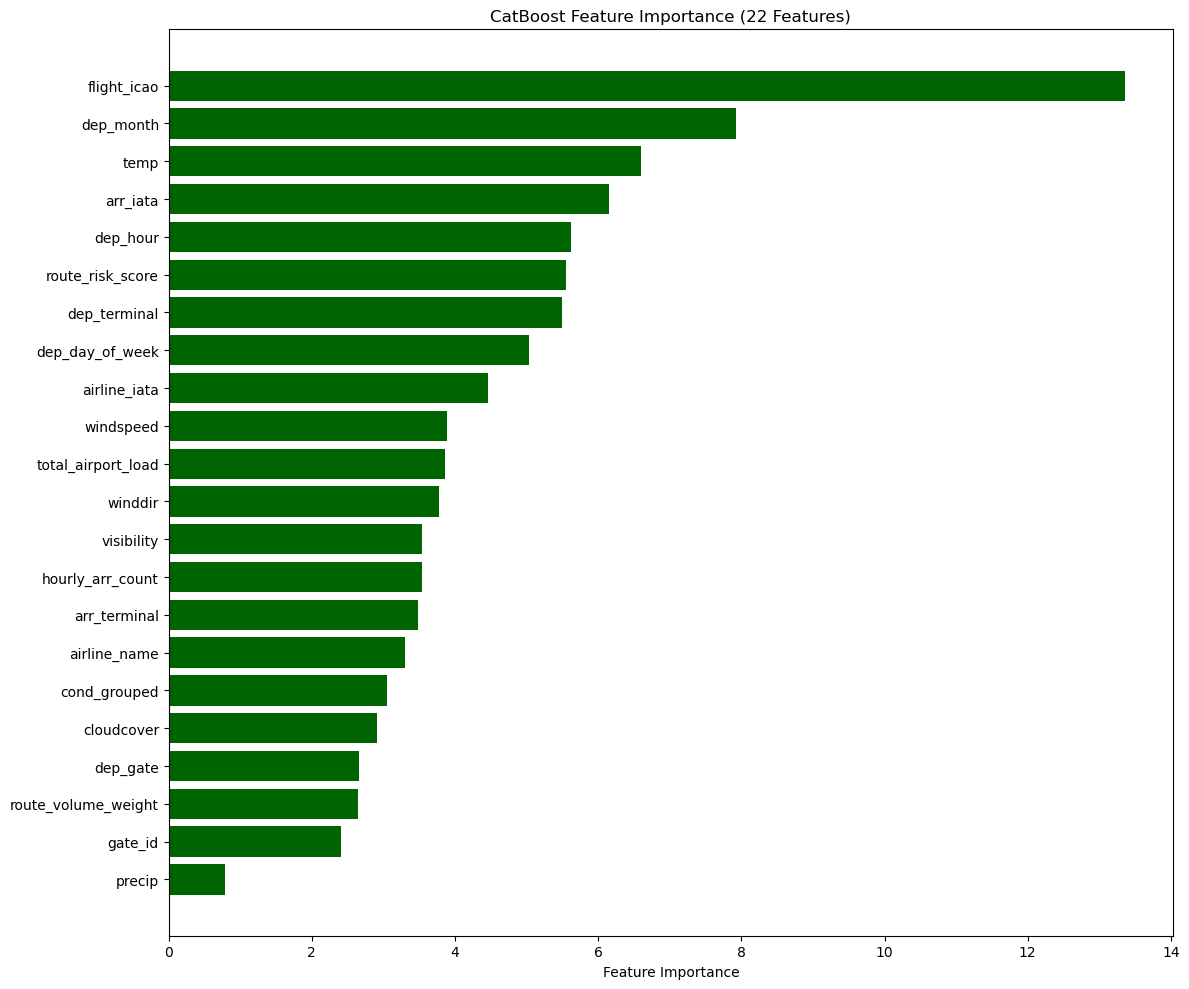


Feature Importance Ranking:
            feature  importance
        flight_icao   13.361264
          dep_month    7.920046
               temp    6.600305
           arr_iata    6.148820
           dep_hour    5.613492
   route_risk_score    5.554095
       dep_terminal    5.489727
    dep_day_of_week    5.025821
       airline_iata    4.457492
          windspeed    3.889944
 total_airport_load    3.853369
            winddir    3.779472
         visibility    3.541560
   hourly_arr_count    3.539549
       arr_terminal    3.484068
       airline_name    3.301372
       cond_grouped    3.049620
         cloudcover    2.907044
           dep_gate    2.660309
route_volume_weight    2.637446
            gate_id    2.404658
             precip    0.780530


In [9]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, roc_auc_score

# Prepare data with categorical features
df_cat = data.copy()

# Fill missing values
df_cat['dep_terminal'] = df_cat['dep_terminal'].fillna('Unknown')
df_cat['dep_gate'] = df_cat['dep_gate'].fillna('Unknown')
df_cat['gate_id'] = df_cat['gate_id'].fillna('Unknown')
df_cat['airline_iata'] = df_cat['airline_iata'].fillna('Unknown')
df_cat['flight_icao'] = df_cat['flight_icao'].fillna('Unknown')

# Numeric columns, fill with median
df_cat['visibility'] = df_cat['visibility'].fillna(df_cat['visibility'].median())

# Create target (25-min threshold)
df_cat['is_delayed_25'] = (df_cat['dep_delay'] >= 25).astype(int)

# Define features
features = [
    # Numeric (11)
    'dep_hour', 'temp', 'precip', 'windspeed', 'winddir', 'visibility', 'cloudcover',
    'hourly_arr_count', 'total_airport_load',
    'route_volume_weight', 'route_risk_score',
    # Categorical (11)
    'dep_terminal', 'dep_gate', 'gate_id',
    'arr_iata', 'arr_terminal',
    'airline_name', 'airline_iata', 'flight_icao',
    'dep_day_of_week', 'dep_month', 'cond_grouped'
]

# Identify categorical feature indices
cat_features = [
    'dep_terminal', 'dep_gate', 'gate_id',
    'arr_iata', 'arr_terminal',
    'airline_name', 'airline_iata', 'flight_icao',
    'dep_day_of_week', 'dep_month', 'cond_grouped'
]
cat_indices = [features.index(f) for f in cat_features]

print(f"Total features: {len(features)}")
print(f"Numeric: {len(features) - len(cat_features)}")
print(f"Categorical: {len(cat_features)}")

X = df_cat[features]
y = df_cat['is_delayed_25']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining: {len(X_train)} | Test: {len(X_test)}")
print(f"Delayed: {y.mean()*100:.1f}% | On-time: {(1-y.mean())*100:.1f}%")

# Train CatBoost
catboost_model = CatBoostClassifier(
    iterations=500,
    depth=8,
    learning_rate=0.1,
    cat_features=cat_indices,
    verbose=100,
    random_state=42,
    auto_class_weights='Balanced'
)

catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

# Evaluate
y_pred = catboost_model.predict(X_test)
y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print("CATBOOST RESULTS")
print("="*60)
print(f"Accuracy: {catboost_model.score(X_test, y_test):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\n" + classification_report(y_test, y_pred, target_names=['On-time', 'Delayed']))

# Feature Importance
importance_df = pd.DataFrame({
    'feature': features,
    'importance': catboost_model.feature_importances_
}).sort_values('importance', ascending=True)

# Plot Feature Importance
plt.figure(figsize=(12, 10))
plt.barh(importance_df['feature'], importance_df['importance'], color='darkgreen')
plt.xlabel('Feature Importance')
plt.title(f'CatBoost Feature Importance ({len(features)} Features)')
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
print(importance_df.sort_values('importance', ascending=False).to_string(index=False))

In [10]:
# Fast CatBoost Optuna Optimization with Pruning
import optuna
from sklearn.metrics import roc_auc_score, recall_score, f1_score
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 200, 500),
        'depth': trial.suggest_int('depth', 4, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 5),
        'cat_features': cat_indices,
        'verbose': 0,
        'random_state': 42,
        'auto_class_weights': 'Balanced',
        'early_stopping_rounds': 30,
        'task_type': 'GPU',  
        'thread_count': -1  
    }
    
    # Train model
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0)
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Optimize for recall at threshold 0.35
    y_pred_035 = (y_pred_proba >= 0.35).astype(int)
    recall = recall_score(y_test, y_pred_035)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    score = 0.6 * recall + 0.4 * roc_auc
    
    trial.report(score, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    return score

# Add MedianPruner and TPESampler with seed=42 for reproducibility
study = optuna.create_study(
    direction='maximize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=0)
)
study.optimize(objective_catboost, n_trials=30, show_progress_bar=True)

print(f"\nBest Score: {study.best_value:.4f}")
print(f"Best Params: {study.best_params}")
print(f"Pruned Trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}/{len(study.trials)}")

# Train final model with best params
best_catboost = CatBoostClassifier(
    **study.best_params,
    cat_features=cat_indices,
    verbose=0,
    random_state=42,
    auto_class_weights='Balanced',
    early_stopping_rounds=30
)
best_catboost.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0)

# Evaluate
y_pred_proba = best_catboost.predict_proba(X_test)[:, 1]
y_pred_035 = (y_pred_proba >= 0.35).astype(int)

print("\n" + "="*60)
print("OPTIMIZED CATBOOST RESULTS (Threshold 0.35)")
print("="*60)
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_035):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_035):.4f}")

  0%|          | 0/30 [00:00<?, ?it/s]


Best Score: 0.8223
Best Params: {'iterations': 358, 'depth': 4, 'learning_rate': 0.08454532946915932, 'l2_leaf_reg': 2.6467052990068924}
Pruned Trials: 21/30

OPTIMIZED CATBOOST RESULTS (Threshold 0.35)
ROC-AUC:   0.7429
Recall:    0.8743
F1-Score:  0.6970


In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Prepare data for MLP
X_mlp = df_cat[features].copy()

# Label encode categorical features
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    X_mlp[col] = le.fit_transform(X_mlp[col].astype(str))
    label_encoders[col] = le

# Train-test split with stratification
X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(
    X_mlp, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_mlp)
X_test_scaled = scaler.transform(X_test_mlp)

# Optuna for MLP with Pruning
def objective_mlp(trial):
    hidden_size = trial.suggest_categorical('hidden_size', [
        (128,), (256,), (128, 64), (256, 128), (128, 64, 32), (256, 128, 64)
    ])
    
    params = {
        'hidden_layer_sizes': hidden_size,
        'activation': 'relu', 
        'solver': 'adam',
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-2, log=True),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
        'max_iter': 300,
        'early_stopping': True,
        'validation_fraction': 0.1,
        'n_iter_no_change': 15,
        'random_state': 42,
        'warm_start': False
    }
    
    model = MLPClassifier(**params)
    model.fit(X_train_scaled, y_train_mlp)
    
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    y_pred_035 = (y_pred_proba >= 0.35).astype(int)
    recall = recall_score(y_test_mlp, y_pred_035)
    roc_auc = roc_auc_score(y_test_mlp, y_pred_proba)
    
    # Combine recall and ROC-AUC
    score = 0.6 * recall + 0.4 * roc_auc
    
    # Report and prune
    trial.report(score, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    return score

# Run with pruner
study_mlp = optuna.create_study(
    direction='maximize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5)
)
study_mlp.optimize(objective_mlp, n_trials=15, show_progress_bar=True)

print(f"\nBest Score: {study_mlp.best_value:.4f}")
print(f"Best Params: {study_mlp.best_params}")
print(f"Pruned Trials: {len([t for t in study_mlp.trials if t.state == optuna.trial.TrialState.PRUNED])}/{len(study_mlp.trials)}")

# Train final MLP with best params
best_mlp = MLPClassifier(
    hidden_layer_sizes=study_mlp.best_params['hidden_size'],
    activation='relu',
    solver='adam',
    alpha=study_mlp.best_params['alpha'],
    learning_rate_init=study_mlp.best_params['learning_rate_init'],
    batch_size=study_mlp.best_params['batch_size'],
    max_iter=300,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=42
)
best_mlp.fit(X_train_scaled, y_train_mlp)

# Evaluate
y_pred_proba_mlp = best_mlp.predict_proba(X_test_scaled)[:, 1]
y_pred_mlp_035 = (y_pred_proba_mlp >= 0.35).astype(int)

print("\n" + "="*60)
print("IMPROVED MLP RESULTS (Threshold 0.35)")
print("="*60)
print(f"ROC-AUC:   {roc_auc_score(y_test_mlp, y_pred_proba_mlp):.4f}")
print(f"Recall:    {recall_score(y_test_mlp, y_pred_mlp_035):.4f}")
print(f"F1-Score:  {f1_score(y_test_mlp, y_pred_mlp_035):.4f}")

# Comparison
print(f"{'Model':<20} {'ROC-AUC':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*55)
print(f"{'CatBoost':<20} {roc_auc_score(y_test, y_pred_proba):<12.4f} {recall_score(y_test, y_pred_035):<12.4f} {f1_score(y_test, y_pred_035):<12.4f}")
print(f"{'MLP (Improved)':<20} {roc_auc_score(y_test_mlp, y_pred_proba_mlp):<12.4f} {recall_score(y_test_mlp, y_pred_mlp_035):<12.4f} {f1_score(y_test_mlp, y_pred_mlp_035):<12.4f}")

  0%|          | 0/15 [00:00<?, ?it/s]

c:\Users\javat\anaconda3\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128,) which is of type tuple.
  warnings.warn(message)
c:\Users\javat\anaconda3\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256,) which is of type tuple.
  warnings.warn(message)
c:\Users\javat\anaconda3\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64) which is of type tuple.
  warnings.warn(message)
c:\Users\javat\anaconda3\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent st


Best Score: 0.8035
Best Params: {'hidden_size': (256,), 'alpha': 0.0002273722187988843, 'learning_rate_init': 0.00015293795706465397, 'batch_size': 32}
Pruned Trials: 5/15

IMPROVED MLP RESULTS (Threshold 0.35)
ROC-AUC:   0.6990
Recall:    0.8732
F1-Score:  0.6746
Model                ROC-AUC      Recall       F1-Score    
-------------------------------------------------------
CatBoost             0.7429       0.8743       0.6970      
MLP (Improved)       0.6990       0.8732       0.6746      


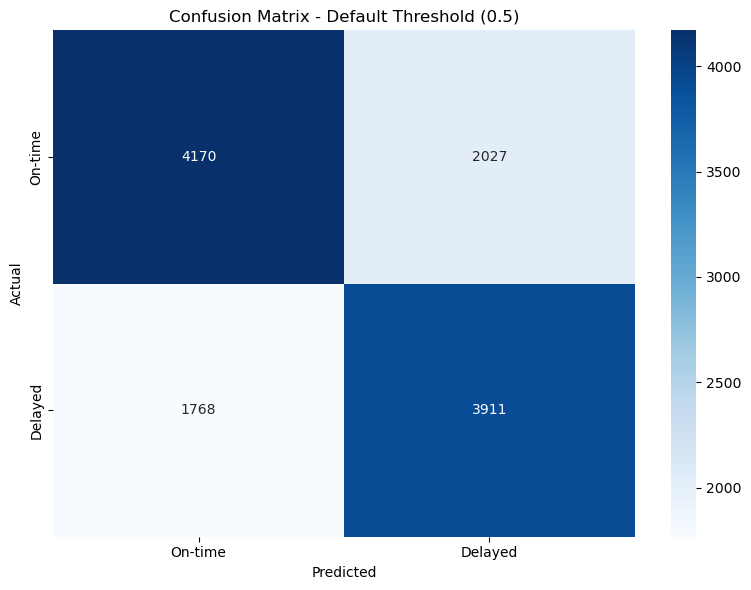


Default Threshold (0.5) Results:
  Recall (Delayed):    0.6887
  Precision (Delayed): 0.6586
  F1-Score (Delayed):  0.6733
  False Negatives:     1768 flights predicted on-time but actually delayed
  False Positives:     2027 flights predicted delayed but actually on-time
 threshold   recall  precision       f1  false_negatives  false_positives
      0.30 0.917943   0.552283 0.689641              466             4226
      0.35 0.874274   0.579549 0.697038              714             3602
      0.40 0.821271   0.606265 0.697577             1015             3029
      0.45 0.759641   0.634225 0.691291             1365             2488
      0.50 0.688678   0.658639 0.673324             1768             2027
      0.55 0.606445   0.686740 0.644099             2235             1571
      0.60 0.522627   0.714836 0.603804             2711             1184


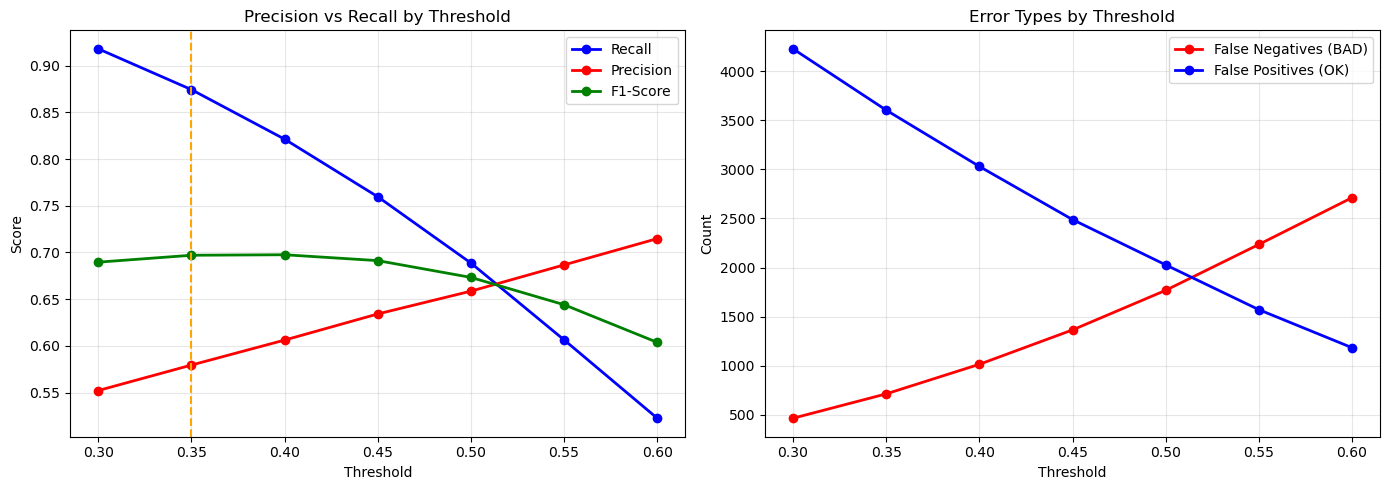

In [12]:
# Prioritizing Recall for Delayed Flights
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    precision_recall_curve, f1_score, recall_score, precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# Current model performance
y_pred = best_catboost.predict(X_test)
y_pred_proba = best_catboost.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['On-time', 'Delayed'],
            yticklabels=['On-time', 'Delayed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Default Threshold (0.5)')
plt.tight_layout()
plt.show()

print(f"\nDefault Threshold (0.5) Results:")
print(f"  Recall (Delayed):    {recall_score(y_test, y_pred):.4f}")
print(f"  Precision (Delayed): {precision_score(y_test, y_pred):.4f}")
print(f"  F1-Score (Delayed):  {f1_score(y_test, y_pred):.4f}")
print(f"  False Negatives:     {cm[1, 0]} flights predicted on-time but actually delayed")
print(f"  False Positives:     {cm[0, 1]} flights predicted delayed but actually on-time")

# Theshold Optimization for High Recall
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
results = []

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    
    recall = recall_score(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    fn = cm_thresh[1, 0]  # False negatives
    fp = cm_thresh[0, 1]  # False positives
    
    results.append({
        'threshold': thresh,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'false_negatives': fn,
        'false_positives': fp
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# Plot Precision-Recall tradeoff
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Metrics by threshold
axes[0].plot(results_df['threshold'], results_df['recall'], 'b-o', label='Recall', linewidth=2)
axes[0].plot(results_df['threshold'], results_df['precision'], 'r-o', label='Precision', linewidth=2)
axes[0].plot(results_df['threshold'], results_df['f1'], 'g-o', label='F1-Score', linewidth=2)
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('Precision vs Recall by Threshold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=0.35, color='orange', linestyle='--', label='Recommended')

# Plot 2: False Negatives vs False Positives
axes[1].plot(results_df['threshold'], results_df['false_negatives'], 'r-o', label='False Negatives (BAD)', linewidth=2)
axes[1].plot(results_df['threshold'], results_df['false_positives'], 'b-o', label='False Positives (OK)', linewidth=2)
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Count')
axes[1].set_title('Error Types by Threshold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

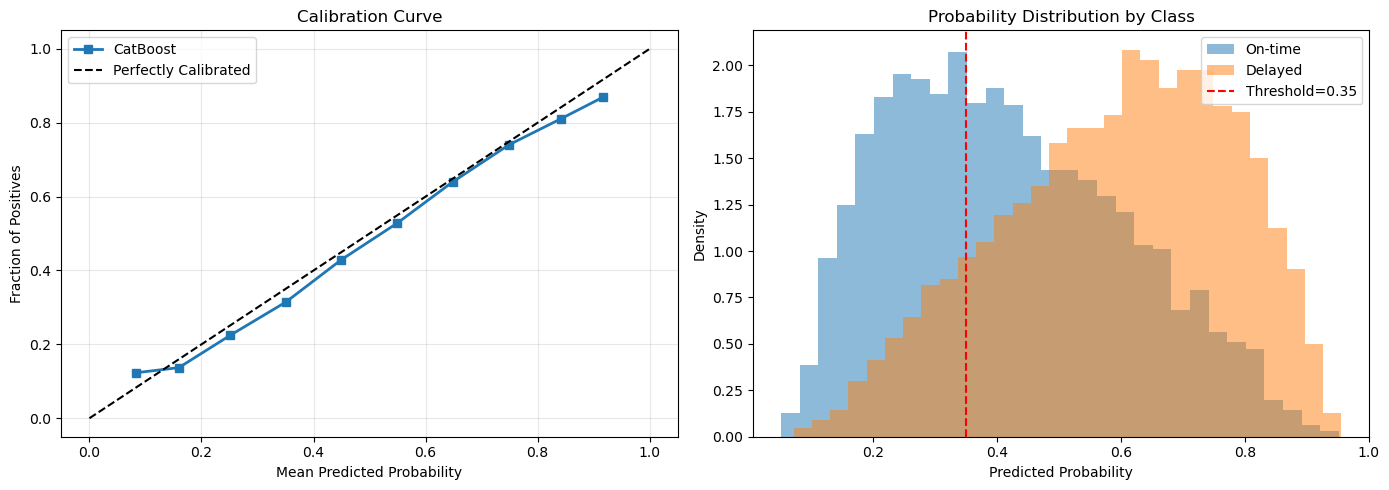


Prediction Tier Analysis:
------------------------------------------------------------
High Risk Delay           | Count:  1620 ( 13.6%) | Actual Delay Rate:  78.9%
Moderate Risk             | Count:  4318 ( 36.4%) | Actual Delay Rate:  61.0%
Low Risk (but flagged)    | Count:  2629 ( 22.1%) | Actual Delay Rate:  40.1%
Likely On-time            | Count:  3309 ( 27.9%) | Actual Delay Rate:  21.6%

Optimal threshold saved: 0.35


In [13]:
# Probability Calibration & Confidence Analysis
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt

# Get predicted probabilities
y_pred_proba = best_catboost.predict_proba(X_test)[:, 1]

# Plot calibration curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
axes[0].plot(prob_pred, prob_true, 's-', label='CatBoost', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
axes[0].set_xlabel('Mean Predicted Probability')
axes[0].set_ylabel('Fraction of Positives')
axes[0].set_title('Calibration Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Probability distribution
axes[1].hist(y_pred_proba[y_test == 0], bins=30, alpha=0.5, label='On-time', density=True)
axes[1].hist(y_pred_proba[y_test == 1], bins=30, alpha=0.5, label='Delayed', density=True)
axes[1].axvline(x=0.35, color='red', linestyle='--', label='Threshold=0.35')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Density')
axes[1].set_title('Probability Distribution by Class')
axes[1].legend()

plt.tight_layout()
plt.show()

# Create prediction tiers based on probability
def get_prediction_tier(prob):
    if prob >= 0.75:
        return 'High Risk Delay'
    elif prob >= 0.50:
        return 'Moderate Risk'
    elif prob >= 0.35:
        return 'Low Risk (but flagged)'
    else:
        return 'Likely On-time'

# Apply tiers
test_results = pd.DataFrame({
    'actual': y_test.values,
    'prob_delayed': y_pred_proba,
    'prediction_0.35': (y_pred_proba >= 0.35).astype(int)
})
test_results['tier'] = test_results['prob_delayed'].apply(get_prediction_tier)

# Analyze each tier
print("\nPrediction Tier Analysis:")
print("-" * 60)
for tier in ['High Risk Delay', 'Moderate Risk', 'Low Risk (but flagged)', 'Likely On-time']:
    tier_data = test_results[test_results['tier'] == tier]
    if len(tier_data) > 0:
        actual_delay_rate = tier_data['actual'].mean() * 100
        count = len(tier_data)
        pct = count / len(test_results) * 100
        print(f"{tier:<25} | Count: {count:>5} ({pct:>5.1f}%) | Actual Delay Rate: {actual_delay_rate:>5.1f}%")

# Save the optimal threshold
OPTIMAL_THRESHOLD = 0.35
print(f"\nOptimal threshold saved: {OPTIMAL_THRESHOLD}")

In [14]:
import joblib

# Save the best model and preprocessing objects
joblib.dump(best_catboost, 'model/catboost_flight_delay_model.pkl')
joblib.dump(features, 'model/model_features.pkl')
joblib.dump(cat_features, 'model/categorical_features.pkl')

print("Model saved successfully!")
print(f"catboost_flight_delay_model.pkl")
print(f"model_features.pkl")
print(f"categorical_features.pkl")

Model saved successfully!
catboost_flight_delay_model.pkl
model_features.pkl
categorical_features.pkl


In [15]:
def predict_flight_delay(flight_data, threshold=0.35):
    """
    Predict delay probability for a flight (delay ≥ 25 minutes).
    
    Parameters:
        flight_data: DataFrame with required features
        threshold: Classification threshold (default 0.35)
    
    Returns:
        Dictionary with prediction, probability, and risk tier
    """
    # Get probability
    prob = best_catboost.predict_proba(flight_data[features])[:, 1][0]
    
    # Determine risk tier
    if prob >= 0.75:
        tier = "HIGH RISK"
        message = "Flight likely delayed 25+ minutes"
    elif prob >= 0.50:
        tier = "MODERATE RISK"
        message = "Possible delay of 25+ minutes"
    elif prob >= threshold:
        tier = "LOW RISK"
        message = "Minor delay (25+ min) possible"
    else:
        tier = "ON SCHEDULE"
        message = "Flight likely on-time or minor delay (<25 min)"
    
    return {
        'probability': round(prob, 3),
        'is_delayed': int(prob >= threshold),
        'risk_tier': tier,
        'message': message,
        'delay_threshold': '25 minutes'
    }

# Test with a sample
sample = X_test.iloc[[1]]
result = predict_flight_delay(sample)
print(f"Sample Prediction: {result}")

Sample Prediction: {'probability': 0.146, 'is_delayed': 0, 'risk_tier': 'ON SCHEDULE', 'message': 'Flight likely on-time or minor delay (<25 min)', 'delay_threshold': '25 minutes'}


In [16]:
print(f"""
MODEL: CatBoost Classifier (Optimized)
TARGET: Departure delay ≥ 25 minutes

HYPERPARAMETERS:
{study.best_params}

PERFORMANCE (Threshold = 0.35):
  ROC-AUC:    {roc_auc_score(y_test, y_pred_proba):.4f}
  Recall:     {recall_score(y_test, y_pred_035):.4f}
  Precision:  {precision_score(y_test, y_pred_035):.4f}
  F1-Score:   {f1_score(y_test, y_pred_035):.4f}

FEATURES USED: {len(features)}
  Numeric:     {len(features) - len(cat_features)}
  Categorical: {len(cat_features)}

TOP 5 IMPORTANT FEATURES:
""")

# Print top 5 features
top_features = importance_df.sort_values('importance', ascending=False).head(5)
for i, row in top_features.iterrows():
    print(f"  {row['feature']:<25} {row['importance']:.2f}")

print("""
USER INPUT (Required):
  flight_icao      - Flight code (e.g., "AAL1234", "UAL567")
  dep_hour         - Scheduled departure hour (0-23)
  dep_day_of_week  - Day of week (0=Monday, 6=Sunday)
  dep_month        - Month (1-12)

LOOKED UP FROM FLIGHT DATA (via flight_icao):
  airline_name     - Airline full name
  airline_iata     - Airline 2-letter code
  arr_iata         - Destination airport code
  arr_terminal     - Arrival terminal
  dep_terminal     - Departure terminal
  dep_gate         - Departure gate
  gate_id          - Gate identifier
  route_volume_weight  - Historical route volume
  route_risk_score     - Historical route delay risk
      
FETCHED FROM EXTERNAL APIs (real-time):
  temp             - Temperature (C)
  precip           - Precipitation (inches)
  windspeed        - Wind speed (mph)
  winddir          - Wind direction (degrees)
  visibility       - Visibility (miles)
  cloudcover       - Cloud cover (%)
  cond_grouped     - Weather condition category

CALCULATED AT PREDICTION TIME:
  hourly_arr_count    - Current hour arrivals
  total_airport_load  - Current airport congestion
      

PREDICTION WORKFLOW:
1. User enters: flight_icao + departure datetime
2. System looks up: airline, route, gate info from database
3. System fetches: current weather from API
4. System calculates: airport load metrics
5. Model predicts: delay probability
6. User sees: risk tier + probability
""")

print(f"""
FILES SAVED:
  catboost_flight_delay_model.pkl
  model_features.pkl
  categorical_features.pkl
""")


MODEL: CatBoost Classifier (Optimized)
TARGET: Departure delay ≥ 25 minutes

HYPERPARAMETERS:
{'iterations': 358, 'depth': 4, 'learning_rate': 0.08454532946915932, 'l2_leaf_reg': 2.6467052990068924}

PERFORMANCE (Threshold = 0.35):
  ROC-AUC:    0.7429
  Recall:     0.8743
  Precision:  0.5795
  F1-Score:   0.6970

FEATURES USED: 22
  Numeric:     11
  Categorical: 11

TOP 5 IMPORTANT FEATURES:

  flight_icao               13.36
  dep_month                 7.92
  temp                      6.60
  arr_iata                  6.15
  dep_hour                  5.61

USER INPUT (Required):
  flight_icao      - Flight code (e.g., "AAL1234", "UAL567")
  dep_hour         - Scheduled departure hour (0-23)
  dep_day_of_week  - Day of week (0=Monday, 6=Sunday)
  dep_month        - Month (1-12)

LOOKED UP FROM FLIGHT DATA (via flight_icao):
  airline_name     - Airline full name
  airline_iata     - Airline 2-letter code
  arr_iata         - Destination airport code
  arr_terminal     - Arrival term